## TL;DR

Scatter shows some grouping of samples under One-vs-All scenario (e.g. worm vs other, etc)

In [4]:
import matplotlib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline
from pandas.plotting import parallel_coordinates
from sklearn.feature_selection import VarianceThreshold

data_folder = '../data/csv_data/'
extension = '.csv.gz'
build_path = lambda x: data_folder + x + extension

df = pd.read_csv(build_path('malwr_behav_api_calls')).set_index('link')
file_info = pd.read_csv(build_path('malwr_file_info'), dtype=str).set_index('link')[['md5']]
file_info.drop_duplicates(keep='last', inplace=True)
df = df[df.index.isin(file_info.index)]
goodware = pd.read_csv(build_path('goodware_real'), dtype=str).link
malware_labeled = pd.read_csv(build_path('malware_labeled'), dtype=str).set_index('link')

goodware = goodware[~goodware.isin(malware_labeled.index)]
malware_labeled = malware_labeled[~malware_labeled.index.isin(goodware)]

#malware_detailed = file_info.join(malware_labeled, on='md5', how='inner').drop('md5', axis=1)
malware_detailed = malware_labeled

malwr_vendors_filtered = pd.read_csv(build_path('malwr_vendors_filtered'), dtype=str).set_index('link')
score = malwr_vendors_filtered.replace('Clean', np.nan).count(axis=1)
ambiguous_score = score[(score < 5) & (score > 0)].index
malware_detailed = malware_detailed[~malware_detailed.index.isin(ambiguous_score)]

df = df[(df.index.isin(goodware)) | (df.index.isin(malware_detailed.index))]

df_stats = df.describe()

In [2]:
display(df_stats)

ControlService     CopyFileA   CopyFileExW     CopyFileW  \
count     3549.000000  19828.000000   1090.000000  12749.000000   
mean        24.266836     62.938420    106.914679     20.175935   
std        345.697027    922.805106   2240.207353    435.455865   
min          1.000000      1.000000      1.000000      1.000000   
25%          1.000000      1.000000      1.000000      1.000000   
50%          3.000000      1.000000      1.000000      1.000000   
75%          4.000000      2.000000      4.000000      2.000000   
max      11872.000000  70479.000000  72574.000000  33853.000000   

       CreateDirectoryExW  CreateDirectoryW  CreateProcessInternalW  \
count           84.000000      47067.000000            66712.000000   
mean           322.202381         24.874264               56.569253   
std           2127.797689        595.340041              875.959371   
min              1.000000          1.000000                1.000000   
25%              1.000000          1.000000                1.000000   
50%              2.000000          3.000000                2.000000   
75%              4.000000          7.000000                3.000000   
max          17241.000000     111327.000000           118761.000000   

       CreateRemoteThread  CreateServiceA  CreateServiceW     ...      \
count        21461.000000     6278.000000     1615.000000     ...       
mean             9.005498        1.631889        1.190093     ...       
std             59.834457       16.639312        0.878153     ...       
min              1.000000        1.000000        1.000000     ...       
25%              1.000000        1.000000        1.000000     ...       
50%              2.000000        1.000000        1.000000     ...       
75%              5.000000        1.000000        1.000000     ...       
max           5061.000000      824.000000       29.000000     ...       

            listen           recv       recvfrom         select          send  \
count  5609.000000   15186.000000    2590.000000   20140.000000  30349.000000   
mean      2.371902     917.314434    1571.003089     865.996524    110.568487   
std      28.905147    7657.105504   14429.546418   11973.984131   1419.368170   
min       1.000000       1.000000       1.000000       1.000000      1.000000   
25%       1.000000       2.000000       4.000000       2.000000      2.000000   
50%       1.000000      10.000000      22.000000      20.000000      4.000000   
75%       1.000000      59.000000      63.000000      99.000000     15.000000   
max    2000.000000  429975.000000  386395.000000  698645.000000  77800.000000   

              sendto     setsockopt       shutdown         socket      system  
count    3264.000000   28551.000000   11196.000000   41601.000000   55.000000  
mean      268.609988      91.625477      71.596552     174.296291    9.145455  
std      2764.106297    1421.670307    1853.311248    4293.134981   33.386301  
min         1.000000       1.000000       1.000000       1.000000    1.000000  
25%         4.000000       3.000000       1.000000       1.000000    1.000000  
50%        14.000000       8.000000       4.000000       3.000000    2.000000  
75%        36.000000      26.000000      25.000000       8.000000    2.500000  
max    131692.000000  132446.000000  109034.000000  415765.000000  232.000000  

[8 rows x 163 columns]

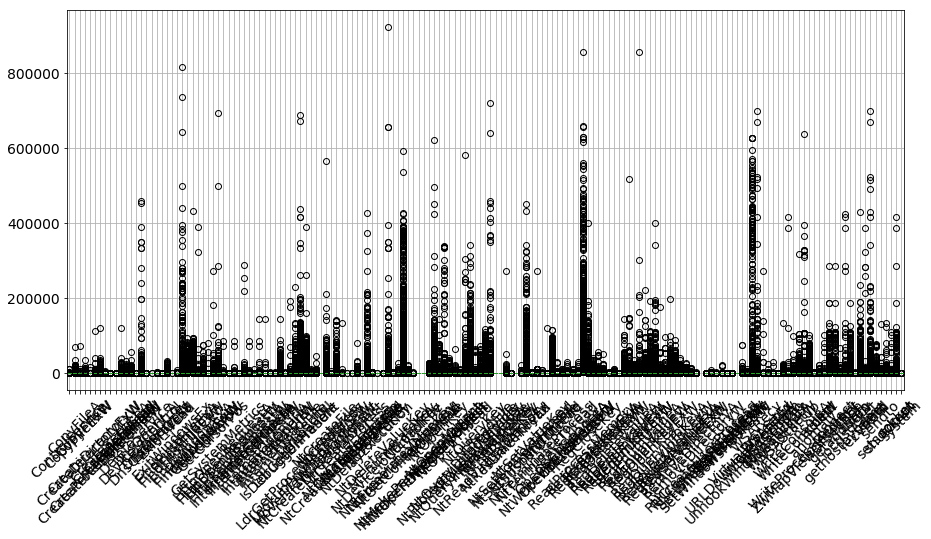

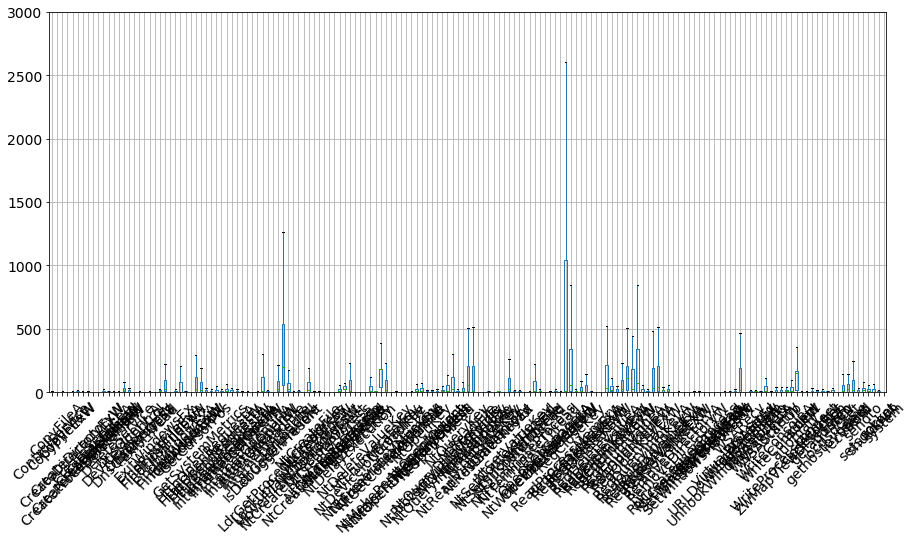

In [7]:
matplotlib.rcParams.update({'font.size': 14})
df.boxplot(figsize=(15,7), rot=45)
plt.show()
df.boxplot(figsize=(15,7), rot=45, showfliers=False)
plt.ylim(-1, 3000)
plt.show()

In [8]:
rescaledX = QuantileTransformer(output_distribution='normal').fit_transform(df.fillna(0))
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(rescaledX)

In [9]:
display(rescaledX.shape)
vt = VarianceThreshold(threshold=(.80 * (1 - .80)))
var_matrix = vt.fit_transform(rescaledX)
indices = np.where(var_matrix.sum(axis=1) > 0)[0]
# df = df.iloc[indices, :]
var_matrix = var_matrix[indices]
display(var_matrix.shape)

(148035, 163)

(53, 144)

In [10]:
df.loc[:, vt.get_support()]

ControlService  CopyFileA  \
link                                                                     
ODdkNWUzNDQ3ZGI4NDUzYmIyZmY1ZDU2NmI5NWJiYmU             NaN        NaN   
ZDNmZWIwMzBlODhiNDk1MDhhODgyNmI3YTc3NDQzYmI             NaN        NaN   
MTQ5YjJkZGE1YjI5NDJlYjhkOTEzMTlmYzE5MjlmMDc             NaN        NaN   
MmMzODhhNDM1NWE4NGRmMmE1MDc3YjYyMzBmZjFjZGQ             NaN        NaN   
ZDgxZDdlYTQ3MjI1NGE2ZmJjZjNkN2QyYWQ5OWM1MzU             NaN        NaN   
MTMzY2VkZDdiYzQ2NDYyZDg2Y2FkMzZkZmFhNzk2YjY             NaN        5.0   
MzBmMmUxOGUxOTI3NGVjZjhmOTNhYzEyZWYyZjkwMWM             NaN        NaN   
NGViOWQ4M2YyZDM4NGZkM2FmNGNkMDdlYzE2N2E2YWY             NaN        1.0   
YTNiZjc2ODQ5NDI5NDNlNjliOTRlYWU0ZDgxODc2ZDc             NaN        1.0   
NWY2NzlmNjdlNzE5NGZkNmExZDA2MjAxNzUxZTIxZWU             NaN        NaN   
NzFjOWM2ODAzMGYxNDc0YWFiZWE1MzE3YjE1NzI4Yjc             NaN        NaN   
YmRhMmY4YjBkNTM4NDllMTkyZjQzODg3N2ZmNTQwNDE             NaN        NaN   
NzA1OGI1NzU3YzY2NDliMjhjMjFmZWZiNzdkOTM3YTM             NaN        NaN   
NzZlZDA0MzBlZDZhNDZlZmFjNTE5MmZjZjU5ZTBmNWY             NaN        1.0   
Njg2NDVkNzJhZmIxNDJkZTk4OGRlNzNkY2U3M2Y2NjY             NaN        4.0   
ZTQwYTQ4M2U3MDM0NGI1YmFhNjgzMTcwYTcwM2Y2NDU             NaN        1.0   
NTNkNjMyZWUwMjZkNDUyZWI5YWFjYTdlNGQ5OWIwMjY             NaN        1.0   
ZTZhNjE4OTIzNzU2NGVkZWI4MzE3ZTVmYTkyNWEzYWY             NaN        NaN   
NGZhYTU4M2I1NjI4NDYzYjhjZDUzOTFhMzY0NGJiZTU             NaN        NaN   
MTdkZjA0YzY0N2U0NGZlOGJhMmQzMzM5NmY4ZjQxNTg             NaN        NaN   
ZDFkMDdkMGRlMmVhNGU4OTk3MDRjM2I1ZTRmZjI0YjQ             NaN        NaN   
NmVhYTQ3OGM2YTc0NDgyOGIxODcwZjJjMzg3YjZjNzA             NaN       40.0   
Mjk3NmYwOTI4Y2EzNDcxMTk2YjBjNGI2OTA1MDZjOTY             NaN        NaN   
ZjYwNDRhOWJhZjM3NGU4ODllODVjZmNhZDdlZTU4ZTE             NaN        NaN   
MTQzODU2YjBhZDZkNDdhZmI2Njg4ZjFjYzVhYmUyMjg             NaN        NaN   
YTE3ZDE5NmFmOGRkNDdiOGE2OTQwMzgyODgxNTg4NTk             NaN        NaN   
NmNkNjU2ZDE2ZjE3NDRmYmI0ZWE2YTcwMWZkZjlkZjA             NaN        NaN   
NzFjOTAzMzljOWQ1NDExMGI5OTA3YWY4NmE5MGUzOWM             NaN        NaN   
NDIzMzBkZWE1MWM0NDEyOGJiZGE1YjkwYjBhNjU5Y2Y             NaN        NaN   
MTE5N2ZlODk0ZjY0NDU0M2IxOTg3YmRiZTk5YWRjMGI             NaN        NaN   
...                                                     ...        ...   
YjIxOTNiMTBhMmM2NGRmMGIxYmI1NmVmMWEwMmJmZGY             NaN        NaN   
MjNkOGE0MzVlOWY5NDBhNTlkNDhkYjdiZWQ0ZWJhODM             NaN        NaN   
ZjVkMDZjOGZiZGU1NGZjNmIzMDU3YTdlZDlhNDcxMTg             NaN        NaN   
MDQyOTJlZTlmMGJjNDM1MzllNTRkY2NhODcyYWIyNDc             NaN        NaN   
MWMxMmZkMjI5OWRmNGM1MTgyMWNjOGJhNzU4MTI5YjU             NaN        NaN   
M2Y5MTNiNmE5OTJlNDEyMThmOWMwZTc2YzBjOWI3NWQ             NaN        NaN   
NDZmZWJkZGI1OGM0NDIwZDk1NWU5ZDRjZjNlYjM3MGY             NaN        NaN   
OTU4MTM4NTI2ZjY0NGMyY2JiZWZlMjY0N2E2ZWJhZWY             NaN        NaN   
YmU5ZmEyNzZhYjRiNDA2MGIwMWY2ZGFkNTdlYmExZmI             NaN        NaN   
ZGM1YmM0YzE2NmY4NGNjYWE5ZmJiNjdlZjZkNDZlYjQ             NaN        NaN   
ZDg4MmRhMjc0NGRhNGRlNWEzMTcxNzE4YWU4ODkzODM             NaN        NaN   
MjEyMWQxYzAzNTU0NGNkZDk0Nzg4OGNlM2Y3MGU1ZmE             NaN        NaN   
NWYxN2NjZDZjMTkxNDI5YWFhMDc4OWZjZGE4YmRlYTA             NaN        NaN   
ZWNlNTQzMzc1ZmM2NDExMGExYjljNTVjMTE4NmYwNDY             NaN        NaN   
NTgzNGM0MDg5YmIyNDZhYTkxZGQ0NDE0ODAxMDY1ODQ             NaN        NaN   
YTdhZjU2MjczZDM1NDc2OTllYzUzY2QyYWYxMDVjZTE             NaN        NaN   
NTgzYTMzNDJmMGZlNGZhNjkxZDcxN2FkMDNhYjdiOTE             NaN        NaN   
ZmE2ZDRjZmRhMjMxNGI0ZjljN2NhNDAwNjk2OGQ2MGQ             NaN        NaN   
ZGQ1YzZmNTEwNmE1NGJmYzlmYmZlNDFhYTkwYWIxZTc             NaN        NaN   
YzEwYjc0NmU3MDY2NGRiOWI5ZjRiZmIzNDg2YTEyM2I             NaN        NaN   
NzBjY2IzMTczMGI2NDg5YWE0OGUzNmUyZWM1NWFjNGU             NaN        NaN   
NzE5MmMxMzFjYzBiNDNjZmExNWY3ZTY5OGM5NjhjZWI      

In [11]:
learn_ready = pd.DataFrame(rescaledX, index=df.index, columns=df.columns)
learn_ready.loc[learn_ready.index.isin(goodware), 'malware'] = 0
learn_ready.loc[learn_ready.index.isin(malware_detailed.index), 'malware'] = 1
learn_ready.malware = learn_ready.malware.astype(bool)
learn_ready.to_csv(build_path('learn_behav_api_calls2'), compression='gzip')

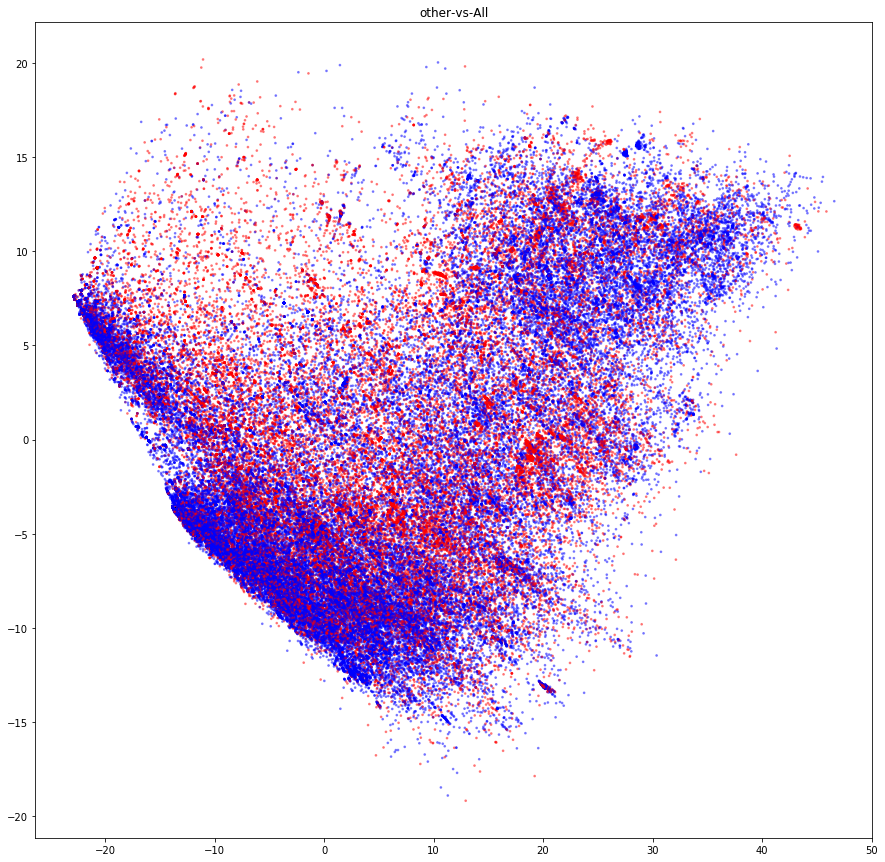

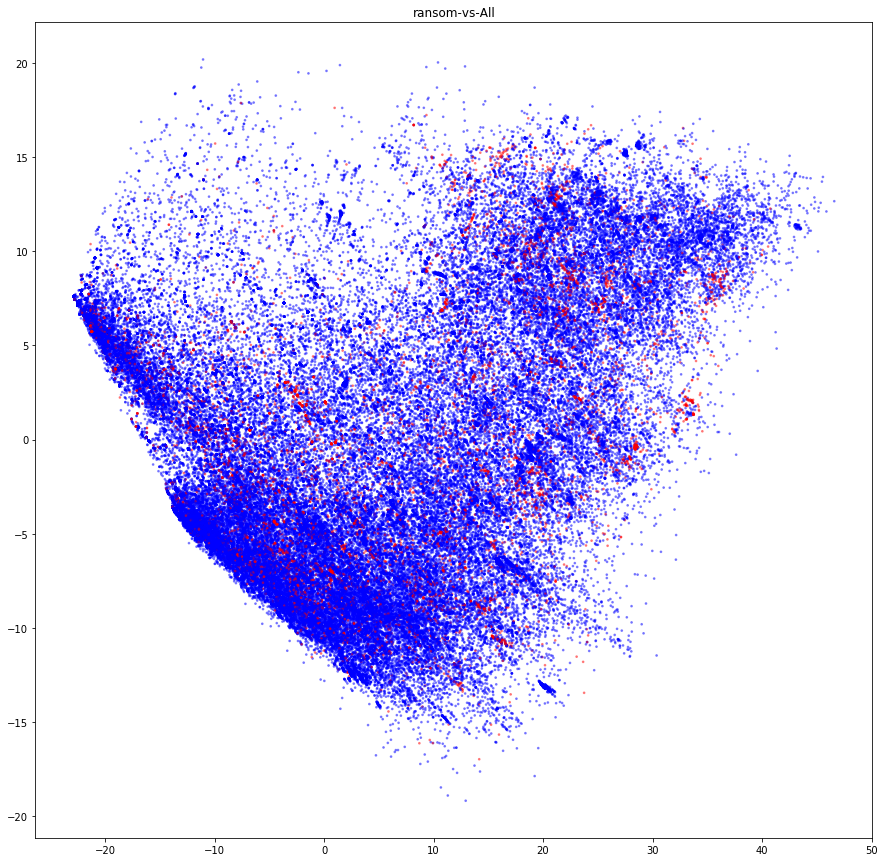

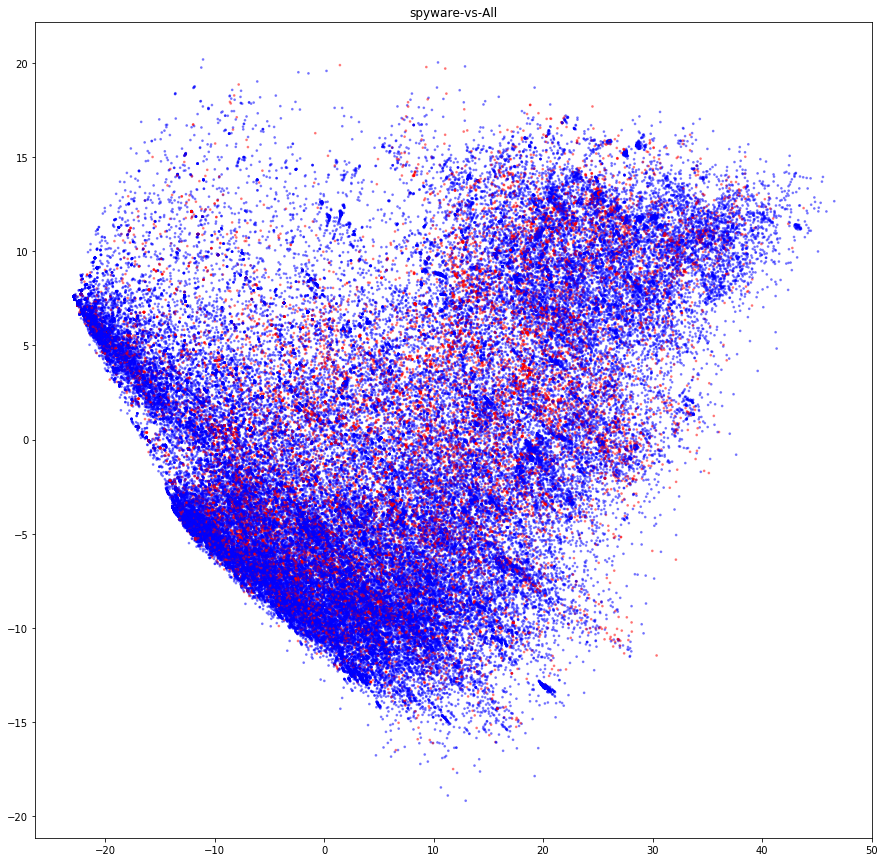

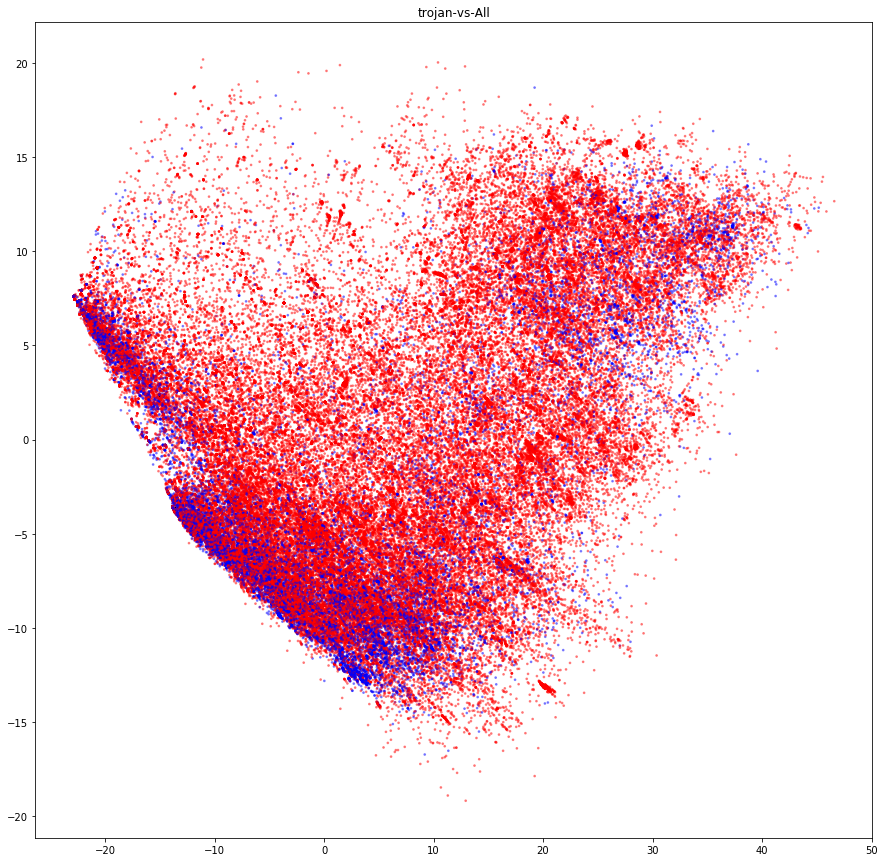

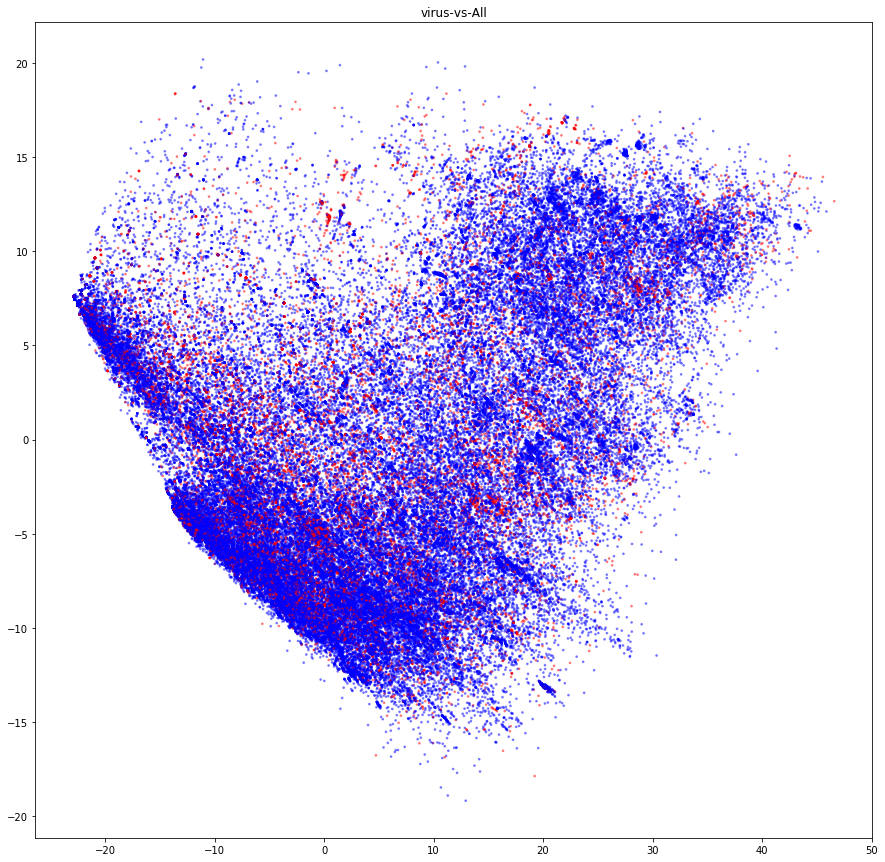

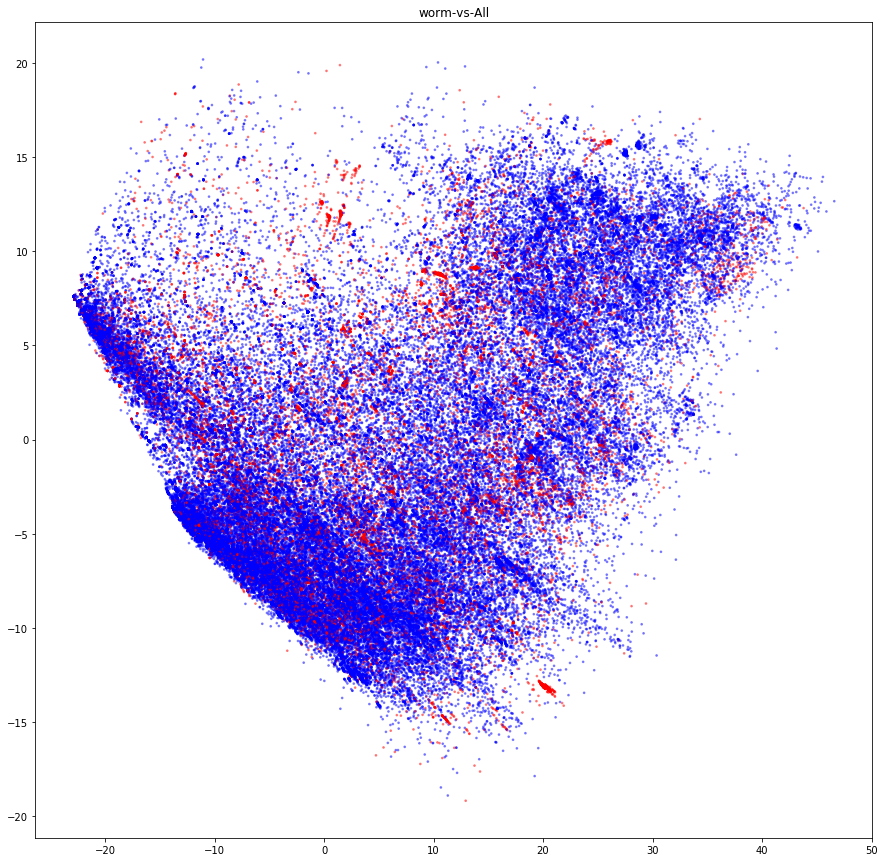

In [8]:
temp = pd.DataFrame(df.index).set_index('link')
for mal_type in malware_detailed.columns:
    malware = malware_detailed[mal_type].dropna()
    temp.loc[:, 'malware'] = 0
    temp.loc[temp.index.isin(malware.index), 'malware'] = 1
    
    plt.figure(figsize=(15, 15))
    plt.scatter(reduced_data[:,0], reduced_data[:,1], c=temp.malware, cmap='bwr', s=3, alpha=0.4)
    plt.title('{}-vs-All'.format(mal_type))
    plt.show()

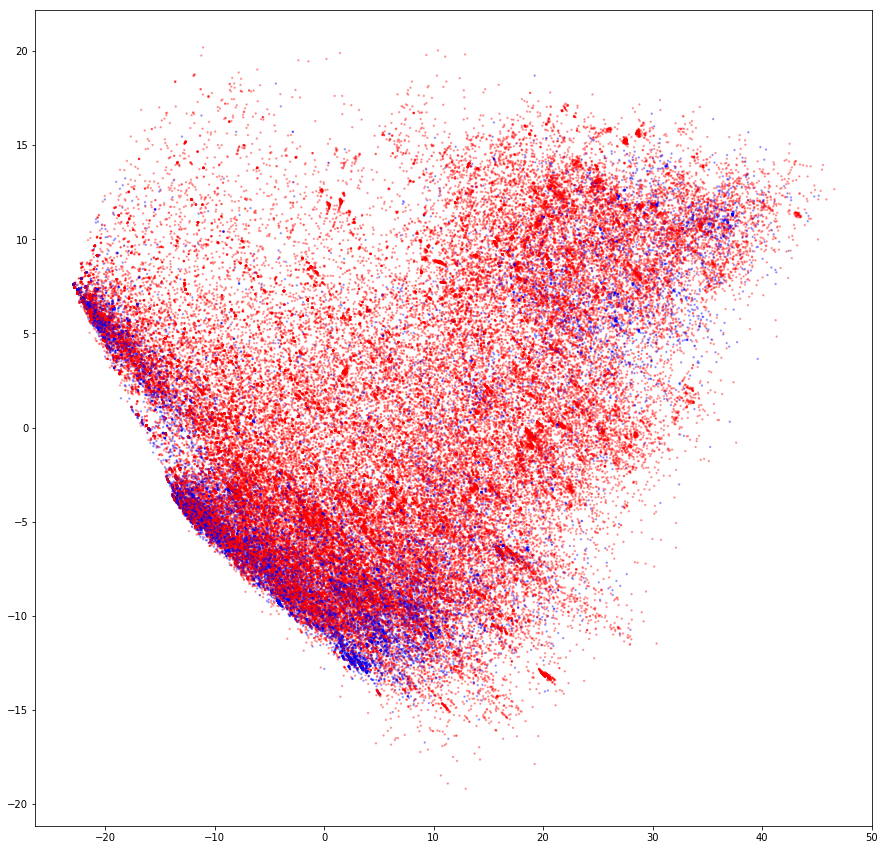

In [9]:
temp = pd.DataFrame(df.index).set_index('link')
temp.loc[:, 'malware'] = 1
temp.loc[temp.index.isin(goodware)] = 0
plt.figure(figsize=(15, 15))
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=temp.malware, cmap='bwr', s=2, alpha=0.3)
plt.show()